In [76]:
import numpy as np
import netCDF4 as nc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, ScalarFormatter
import glob 
from scipy.optimize import curve_fit

%matplotlib widget

In [77]:
fname = '../data/jump_df_threshold1.csv'
jump_df = pd.read_csv(fname)

mission_df = pd.read_csv('../data/mission_df.csv')  

Jump amplitude = 0.04025167982321947
bin width = 0.015410672752273258
Max value in bin = 470.0
Min value in bin = 32.0
[-11.12893922   0.54095645]


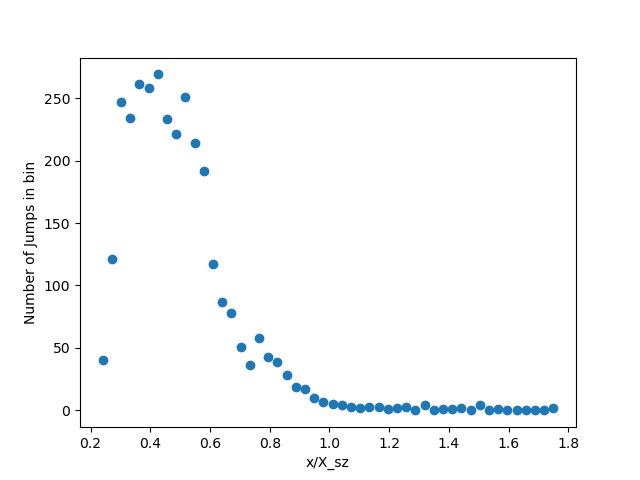

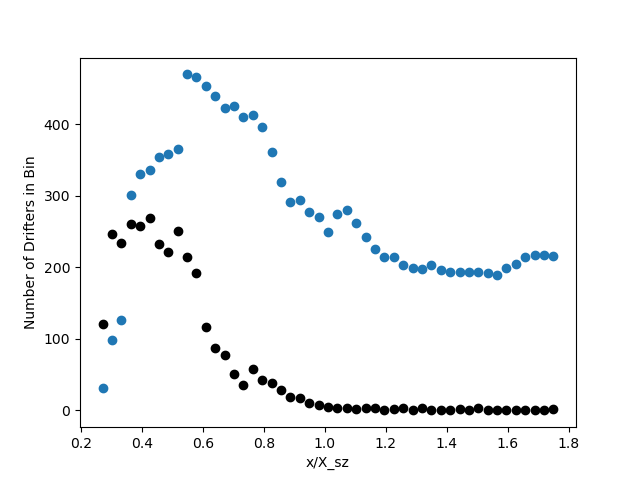

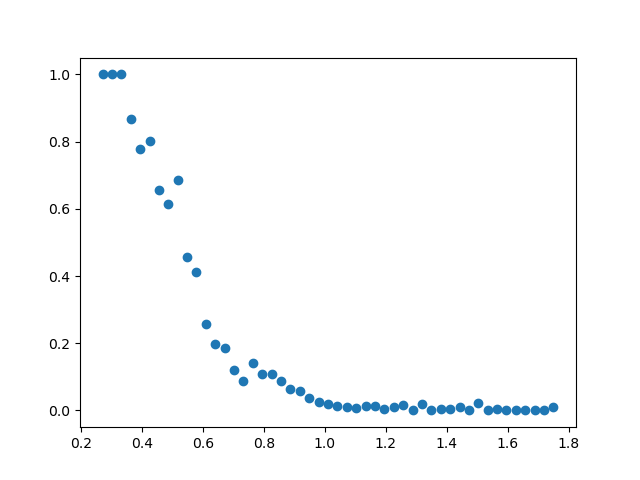

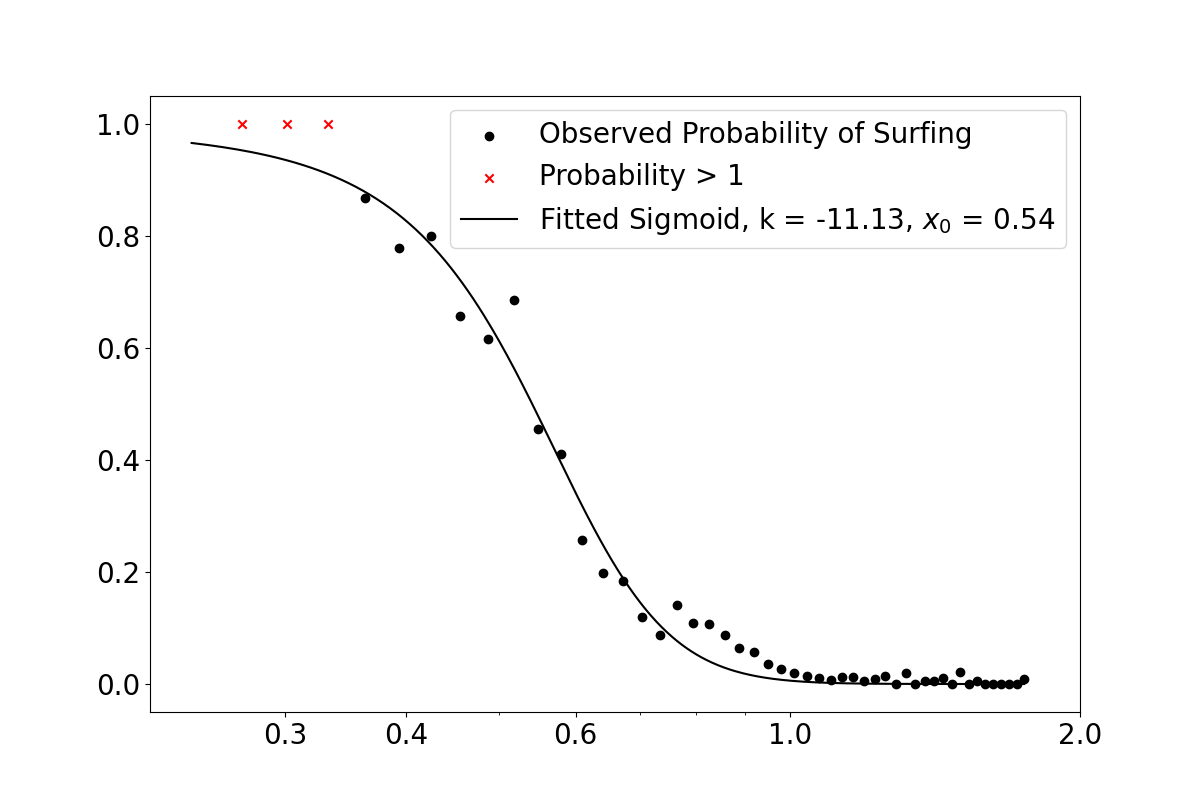

In [82]:
# Compute Frequency of jump locations
normalized_jump_location_hist, normalized_x_bin_edges = np.histogram(jump_df['normalized cross shore jump location [-]'], bins=50)
normalized_x_bin_centers = normalized_x_bin_edges[:-1] + (normalized_x_bin_edges[1] - normalized_x_bin_edges[0])/2

# Print bin width
print(f'Jump amplitude = {np.median(jump_df['jump amplitude [m]'])/np.median(mission_df['surf zone width [m]'])}')
print(f'bin width = {(normalized_x_bin_edges[1] - normalized_x_bin_edges[0])/2}')

fig, ax = plt.subplots()
ax.scatter(normalized_x_bin_centers, normalized_jump_location_hist)
ax.set_xlabel('x/X_sz')
ax.set_ylabel('Number of Jumps in bin')


# Compute number of microswifts in each bin
num_drifters_in_bin = np.zeros(normalized_x_bin_centers.size)

# Get a list of all the missions in the data directory
mission_list = glob.glob('../data/mission_*.nc')
# mission_list = ['../data/mission_19.nc']

for mission_nc in mission_list:
    mission_dataset = nc.Dataset(mission_nc, mode='r')
    mission_num = int(mission_nc[16:-3])
    x_locations = np.ma.masked_invalid(mission_dataset['xFRF'])
    number_of_trajectories = x_locations.shape[0]
    trajectory_numbers = np.arange(number_of_trajectories)

    # Get Surf zone width 
    surf_zone_edge = mission_df[mission_df['mission number'] == mission_num]['surf zone edge [m]'].values[0]
    x_beach = mission_df[mission_df['mission number'] == mission_num]['beach edge [m]'].values[0]
    surf_zone_width = surf_zone_edge - x_beach
    x_normalized = x_locations/surf_zone_width
    
    for n in np.arange(normalized_x_bin_centers.size):
        for trajectory_num in trajectory_numbers:
            if np.any((x_normalized[trajectory_num, :] < normalized_x_bin_edges[n+1])) and np.any((x_normalized[trajectory_num, :] > normalized_x_bin_edges[n])):
                num_drifters_in_bin[n] += 1
            else:
                continue

    mission_dataset.close()

# Exclude bins with zero drifters
good_inds = ~(num_drifters_in_bin == 0)

# Check that no double counts
print(f'Max value in bin = {np.max(num_drifters_in_bin[good_inds])}')
print(f'Min value in bin = {np.min(num_drifters_in_bin[good_inds])}')

# Replace probability greater than 1 with 1
probability_of_surfing = normalized_jump_location_hist[good_inds]/num_drifters_in_bin[good_inds]
probability_of_surfing[probability_of_surfing > 1] = 1

# Plot the number of measurements in each bin
fig, ax = plt.subplots()
ax.scatter(normalized_x_bin_centers[good_inds], num_drifters_in_bin[good_inds], label='num_drifters')
ax.scatter(normalized_x_bin_centers[good_inds], normalized_jump_location_hist[good_inds], color='k', label='jumps')
ax.set_xlabel('x/X_sz')
ax.set_ylabel('Number of Drifters in Bin')


fig, ax = plt.subplots()
ax.scatter(normalized_x_bin_centers[good_inds], probability_of_surfing)


def sigmoid_function(x, k, x0):
    return (1 / (1 + np.exp(-k*(x-x0))))

initial_guess = [1, 1]  # Adjust as needed

# Fit the curve
popt, pcov = curve_fit(sigmoid_function, normalized_x_bin_centers[good_inds], probability_of_surfing, p0=initial_guess)

print(popt)

x_plot = np.linspace(min(normalized_x_bin_centers), max(normalized_x_bin_centers), 500)
y_plot = sigmoid_function(x_plot, *popt)

# find 100% inds - mark on scatter plot
max_inds = probability_of_surfing == 1

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(normalized_x_bin_centers[good_inds][~max_inds], probability_of_surfing[~max_inds], color='k', label='Observed Probability of Surfing')
ax.scatter(normalized_x_bin_centers[good_inds][max_inds], probability_of_surfing[max_inds], color='r', marker='x', label='Probability > 1')
ax.plot(x_plot, y_plot, label=f'Fitted Sigmoid, k = {np.round(popt[0], 2)}, $x_0$ = {np.round(popt[1], 2)}', color='k')
# ax.set_xlabel('x/L_sz')
# ax.set_ylabel('Number of Surfing Events/ Number of Times Area Sampled')
ax.set_xscale('log')
ax.legend(fontsize=20)
ax.tick_params(axis='both', labelsize=20)
ax.set_xticks([0.3, 0.4, 0.6, 1, 2])
# ax.set_xticks([0.5, 1, 5])
ax.get_xaxis().set_major_formatter(ScalarFormatter())